# Forecasting prices

## Overview

Train several models to see what's the better performance.

Models:

* KNN
* ARIMA Model
* Bagging
* Boosting

## Import libraries

In [ ]:
import sys
!{sys.executable} -m  conda install -c anaconda keras

Solving environment: done

## Package Plan ##

  environment location: /home/emi/miniconda3py37

  added / updated specs: 
    - keras


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    lxml-4.2.5                 |   py36hefd8a0e_0         1.6 MB  anaconda
    numpy-1.15.4               |   py36h1d66e8a_0          35 KB  anaconda
    tensorflow-base-1.12.0     |mkl_py36h3c3e929_0        98.5 MB  anaconda
    wheel-0.32.3               |           py36_0          35 KB  anaconda
    pandas-datareader-0.7.0    |           py36_0         142 KB  anaconda
    conda-4.5.12               |           py36_0         1.0 MB
    gast-0.2.0                 |           py36_0          15 KB  anaconda
    requests-2.20.1            |           py36_0          85 KB  anaconda
    entrypoints-0.2.3          |           py36_2           9 KB  anaconda
    mkl_random-1.0.1           |   py36h4414c95_1    

In [183]:
import datetime as dt
import os
import pandas as pd
import numpy as np
import csv
import warnings
from pandas import Series

# Files
from indicators import get_momentum, get_RSI, get_sma, plot_stock_prices_prediction
from util import fetchOnlineData, slice_df

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import tree, metrics, neighbors

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# ARIMA
import statsmodels
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf

# LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#Bagging
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Neural Network
from sklearn.neural_network import MLPClassifier


# Add plotly for interactive charts
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools



ModuleNotFoundError: No module named 'keras'

## Initial variables

In [132]:
symbol = "AABA"

# We'll look back 365 days
start_d = dt.date.today() - dt.timedelta(365)

## Getting data from Yahoo

In [133]:
yesterday = dt.date.today() - dt.timedelta(1)
portf_value = fetchOnlineData(start_d, symbol, yesterday)

[*********************100%***********************]  1 of 1 downloaded


In [134]:
# Normalize the prices Dataframe
normed = portf_value.copy()

In [ ]:
# Convert price column to float
#normed[symbol] = pd.to_numeric(normed[symbol], downcast='float', errors='coerce').fillna(0)

In [136]:
normed.info()
normed.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2018-01-22 to 2019-01-18
Data columns (total 1 columns):
Adj Close    251 non-null float64
dtypes: float64(1)
memory usage: 3.9 KB


,Adj Close
Date,
2018-01-22,74.160004
2018-01-23,76.570000
2018-01-24,77.809998
2018-01-25,78.580002
2018-01-26,80.300003


## Getting indicator values

In [137]:
def get_indicators(normed, symbol):

    # Compute momentum
    sym_mom = get_momentum(normed[symbol], window=10)

    # ****Relative Strength Index (RSI)****
    # Compute RSI
    rsi_value = get_RSI(normed[symbol], 7)

    # ****Simple moving average (SMA)****
    # Compute SMA
    sma, q = get_sma(normed[symbol], window=10)
    return sym_mom, sma, q, rsi_value

#normed = scaling_data(normed, symbol)

normed['date'] = portf_value.index
normed.set_index('date', inplace=True)
normed.rename(columns={'Adj Close': symbol}, inplace=True)


In [138]:
# Get indicators
sym_mom, sma, q, rsi_value = get_indicators(normed, symbol)


# Create momentum column
normed['Momentum'] = sym_mom

# Create SMA column
normed['SMA'] = sma

# Create SMA column
normed['RSI'] = rsi_value

date
2018-02-05   -0.022249
2018-02-06   -0.039702
2018-02-07   -0.072613
2018-02-08   -0.120005
2018-02-09   -0.122291
2018-02-12   -0.103857
2018-02-13   -0.088923
2018-02-14   -0.077867
2018-02-15   -0.021181
2018-02-16   -0.011962
2018-02-20    0.028686
2018-02-21    0.021488
2018-02-22    0.046563
2018-02-23    0.124512
2018-02-26    0.107832
2018-02-27    0.070745
2018-02-28    0.049642
2018-03-01    0.001086
2018-03-02   -0.022984
2018-03-05   -0.000952
2018-03-06    0.007776
2018-03-07    0.011583
2018-03-08    0.002781
2018-03-09   -0.014660
2018-03-12   -0.006660
2018-03-13   -0.002102
2018-03-14    0.031396
2018-03-15    0.077027
2018-03-16    0.099188
2018-03-19    0.059913
                ...   
2018-12-06    0.048777
2018-12-07    0.013837
2018-12-10   -0.002724
2018-12-11   -0.027963
2018-12-12   -0.020885
2018-12-13   -0.040807
2018-12-14   -0.037411
2018-12-17   -0.084007
2018-12-18   -0.115235
2018-12-19   -0.109568
2018-12-20   -0.111964
2018-12-21   -0.116807
2018-1

In [139]:
normed.info()
# Clean nan values
normed = normed.fillna(0)

# Sort dataframe by index
normed.sort_index()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2018-01-22 to 2019-01-18
Data columns (total 4 columns):
AABA        251 non-null float64
Momentum    241 non-null float64
SMA         242 non-null float64
RSI         251 non-null float64
dtypes: float64(4)
memory usage: 9.8 KB


,AABA,Momentum,SMA,RSI
date,,,,
2018-01-22,74.160004,0.000000,0.000000,56.776549
2018-01-23,76.570000,0.000000,0.000000,56.776549
2018-01-24,77.809998,0.000000,0.000000,56.776549
2018-01-25,78.580002,0.000000,0.000000,56.776549
2018-01-26,80.300003,0.000000,0.000000,56.776549
2018-01-29,79.339996,0.000000,0.000000,56.776549
2018-01-30,78.269997,0.000000,0.000000,56.776549
2018-01-31,79.879997,0.000000,0.000000,62.004931
2018-02-01,76.010002,0.000000,0.000000,46.299349


In [140]:
#missing data
total = normed.isnull().sum().sort_values(ascending=False)
percent = (normed.isnull().sum()/normed.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

          Total  Percent
RSI           0      0.0
SMA           0      0.0
Momentum      0      0.0
AABA          0      0.0


In [141]:
corr_df = normed.corr(method='pearson')
print("--------------- CORRELATIONS ---------------")
print(corr_df)

# Define X and y
feature_cols = ['Momentum', 'RSI']
X = normed[feature_cols]
y = normed[symbol]

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

--------------- CORRELATIONS ---------------
              AABA  Momentum       SMA       RSI
AABA      1.000000  0.300007  0.187497  0.437419
Momentum  0.300007  1.000000 -0.008723  0.847988
SMA       0.187497 -0.008723  1.000000 -0.024710
RSI       0.437419  0.847988 -0.024710  1.000000


# Decision Tree Regressor

In [142]:
'''
# Use only to get the best parameter for max_depth
# Loop through a few different max depths and check the performance
for d in [3, 5, 10]:
    # Create the tree and fit it
    decision_tree = tree.DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(X_train, y_train)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(X_train, y_train))
    print(decision_tree.score(X_test, y_test), '\n')
'''

"\n# Use only to get the best parameter for max_depth\n# Loop through a few different max depths and check the performance\nfor d in [3, 5, 10]:\n    # Create the tree and fit it\n    decision_tree = tree.DecisionTreeRegressor(max_depth=d)\n    decision_tree.fit(X_train, y_train)\n\n    # Print out the scores on train and test\n    print('max_depth=', str(d))\n    print(decision_tree.score(X_train, y_train))\n    print(decision_tree.score(X_test, y_test), '\n')\n"

In [143]:
def model_fit_pred(X_train, y_train, X_test):
    '''Fit a model and get predictions and metrics'''
    
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Measuring predictions

    # Accuracy
    scores = cross_val_score(model, X_test, y_test, cv=10)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() / 2))

    # Coefficient of determination R^2
    '''
    The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.
    '''
    coef_deter = model.score(X_train, y_train)
    print('Coefficient of determination R^2: %s' % coef_deter)

    # Forecast error
    '''
    The units of the forecast error are the same as the units of the prediction. A forecast error of zero indicates no error, or perfect skill for that forecast.
    '''
    forecast_errors = [y_test[i] - y_pred[i] for i in range(len(y_test))]
    print('Forecast Errors: %s' % forecast_errors)

    # Forecast bias
    '''
    Mean forecast error, also known as the forecast bias. A forecast bias of zero, or a very small number near zero, shows an unbiased model.
    '''
    bias = sum(forecast_errors) * 1.0 / len(y_test)
    print('Bias: %f' % bias)

    # Mean absolute error
    '''
    A mean absolute error of zero indicates no error.
    '''
    mae = metrics.mean_absolute_error(y_test, y_pred)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

    # Mean squared error
    '''
    A mean squared error of zero indicates perfect skill, or no error.
    '''
    mse = metrics.mean_squared_error(y_test, y_pred)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

    # Root mean squared error
    '''
    As with the mean squared error, an RMSE of zero indicates no error.
    '''
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

    results = pd.DataFrame({'Price': y_test, 'Price prediction': y_pred})
    results.sort_index(inplace=True)

    return results, coef_deter, forecast_errors, bias, mae, mse, rmse

## Creating the model

In [144]:
model = tree.DecisionTreeRegressor(max_depth=10)
results, coef_deter, forecast_errors, bias, mae, mse, rmse = model_fit_pred(X_train, y_train, X_test)

Accuracy: -5.77 (+/- 2.28)
Coefficient of determination R^2: 0.9789414268921619
Forecast Errors: [-5.514288714285726, -6.124289714285723, -2.8075007500000027, -7.669998333333339, 0.29000100000000373, -12.369998999999993, -5.520001000000001, -10.740002000000004, -9.220002000000001, -9.329997999999996, -9.550002999999997, -3.6899950000000032, -8.433335333333332, -10.420001999999997, -11.525002000000008, -11.310001, -18.270004999999998, -10.987500750000002, -9.317498749999999, -13.010002000000007, -11.610000000000007, -13.995003000000004, -10.130001499999992, -9.45999899999999, -13.53499949999999, -9.360000499999991, -6.190002999999997, -15.819999999999993, -5.45000000000001, -9.077500750000006, -12.804285714285726, -6.379997000000003, -5.65000100000001, -13.040001000000004, -8.72999999999999, -10.534285714285723, -8.190003000000011, -8.07999749999999, -13.61, -14.699996999999996, -4.189993999999999, -16.93000099999999, -10.690003000000004, -16.020004999999998, -10.70999900000001, -5.6299

## Plotting predictioons

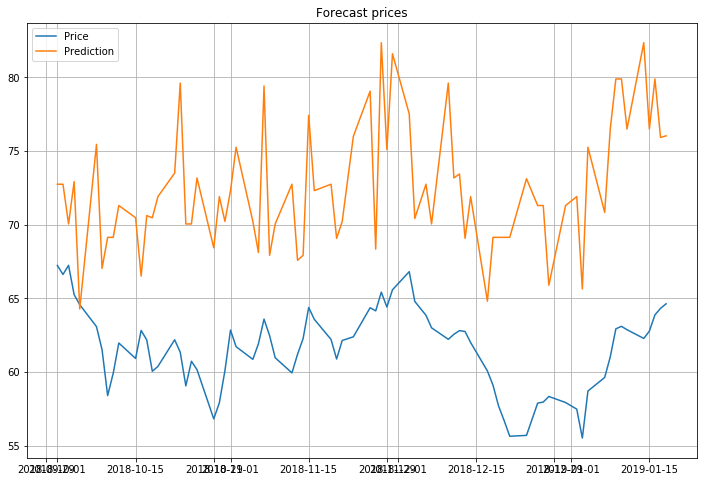

In [152]:
# Plot prediction
plt.figure(figsize=(12,8))
plt.plot(X_test.index, results['Price'], label='Price')
plt.plot(X_test.index,results['Price prediction'], label='Prediction')
plt.title("Forecast prices")
plt.legend()
plt.grid()
plt.show()

# KNN Model

## Creating the model

In [153]:
params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
knn = neighbors.KNeighborsRegressor()
print('KNN: %s' % knn)
model = GridSearchCV(knn, params, cv=5)

KNN: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')


In [154]:
results, coef_deter, forecast_errors, bias, mae, mse, rmse = model_fit_pred(X_train, y_train, X_test)

/home/emi/miniconda3py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/home/emi/miniconda3py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/home/emi/miniconda3py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/home/emi/miniconda3py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The defaul

Accuracy: -1.98 (+/- 1.82)
Coefficient of determination R^2: 0.5956085745851487
Forecast Errors: [-4.956670000000003, -4.946668333333335, -6.596664333333337, -5.983329999999995, -4.826665333333338, -6.046666666666667, -6.6066656666666645, -9.716665666666671, -10.620000666666677, -10.626666666666672, -11.466667333333326, -11.016662333333336, -9.540001666666669, -10.509998666666661, -8.953336333333347, -9.966666000000004, -9.97333566666667, -13.040000666666664, -10.483333333333334, -15.190002333333332, -14.063330999999998, -13.856669333333322, -12.066669000000005, -9.806665666666667, -12.826665999999996, -12.240001666666664, -9.219998999999994, -14.070002666666667, -8.669998999999997, -12.190001000000002, -15.409999333333332, -11.083333666666675, -11.086667333333331, -15.686668999999995, -8.900000333333324, -10.889999666666661, -13.416669666666671, -9.45333033333334, -8.543329333333332, -12.39333333333333, -11.806660666666659, -13.089999333333324, -11.340004000000008, -14.486671999999999

/home/emi/miniconda3py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



## Ploting predictions

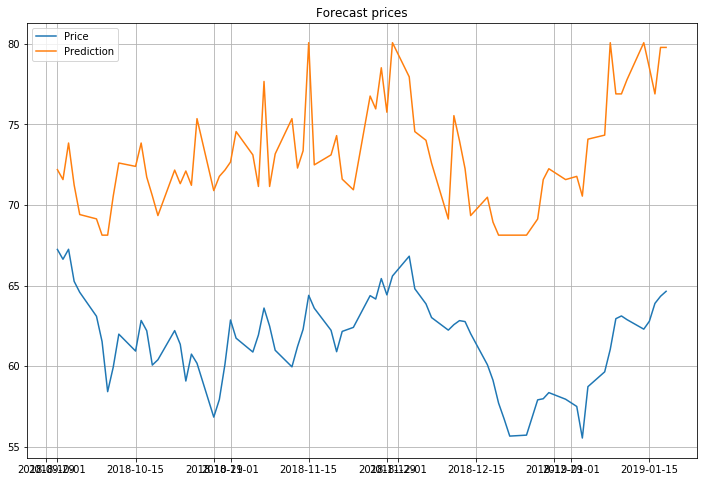

In [155]:
# Plot prediction
plt.figure(figsize=(12,8))
plt.plot(X_test.index, results['Price'], label='Price')
plt.plot(X_test.index,results['Price prediction'], label='Prediction')
plt.title("Forecast prices")
plt.legend()
plt.grid()
plt.show()

# ARIMA Model

In [25]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [26]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

## Getting best parameters values

In [29]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=24.927
ARIMA(0, 0, 1) MSE=8.214
ARIMA(0, 0, 2) MSE=3.401
ARIMA(0, 1, 0) MSE=2.031
ARIMA(0, 1, 1) MSE=2.239
ARIMA(0, 1, 2) MSE=4.172
ARIMA(0, 2, 0) MSE=3.202
ARIMA(0, 2, 1) MSE=3.383
ARIMA(0, 2, 2) MSE=2.942
ARIMA(1, 0, 0) MSE=2.588
ARIMA(1, 0, 1) MSE=3.160
ARIMA(1, 0, 2) MSE=2.753
ARIMA(1, 1, 0) MSE=2.102
ARIMA(1, 2, 0) MSE=3.335
ARIMA(2, 1, 0) MSE=2.309
ARIMA(2, 2, 0) MSE=3.411
ARIMA(2, 2, 1) MSE=4.181
ARIMA(4, 0, 0) MSE=2.563
ARIMA(4, 1, 0) MSE=2.153
ARIMA(4, 1, 1) MSE=2.472
ARIMA(4, 2, 0) MSE=3.086
ARIMA(6, 0, 1) MSE=3.108
ARIMA(6, 1, 0) MSE=2.195
ARIMA(6, 1, 1) MSE=2.191
ARIMA(6, 1, 2) MSE=5.428
ARIMA(6, 2, 0) MSE=2.765
ARIMA(8, 0, 0) MSE=2.999
ARIMA(8, 0, 1) MSE=2.978
ARIMA(8, 0, 2) MSE=3.097
ARIMA(8, 1, 0) MSE=3.076
ARIMA(8, 1, 1) MSE=3.148
ARIMA(8, 1, 2) MSE=3.849
ARIMA(8, 2, 0) MSE=4.572
ARIMA(10, 0, 0) MSE=3.076
ARIMA(10, 1, 0) MSE=3.137
ARIMA(10, 1, 1) MSE=3.352
ARIMA(10, 2, 0) MSE=5.501
Best ARIMA(0, 1, 0) MSE=2.031


## Fitting model and plotting

predicted=64.375608, expected=62.480000
predicted=63.232771, expected=60.980000
predicted=61.705952, expected=59.950001
predicted=60.655295, expected=61.209999
predicted=61.921743, expected=62.279999
predicted=62.995861, expected=64.389999
predicted=65.121704, expected=63.590000
predicted=64.304494, expected=62.220001
predicted=62.911334, expected=60.889999
predicted=61.559120, expected=62.150002
predicted=62.825546, expected=62.400002
predicted=63.070970, expected=64.370003
predicted=65.054790, expected=64.160004
predicted=64.835372, expected=65.430000
predicted=66.111563, expected=64.419998
predicted=65.084122, expected=65.589996
predicted=66.259282, expected=66.820000
predicted=67.494949, expected=64.800003
predicted=65.448003, expected=63.860001
predicted=64.492278, expected=63.009998
predicted=63.627743, expected=62.230000
predicted=62.834175, expected=62.570000
predicted=63.171635, expected=62.820000
predicted=63.418286, expected=62.759998
predicted=63.352073, expected=62.009998


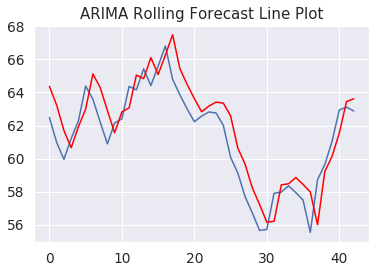

In [85]:
series =  pd.Series(normed[symbol].values)

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.title("ARIMA Rolling Forecast Line Plot")
plt.show()

## Showing summary

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  124
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -414.017
Method:                           css   S.D. of innovations              6.820
Date:                Thu, 17 Jan 2019   AIC                            832.033
Time:                        20:46:10   BIC                            837.674
Sample:                             1   HQIC                           834.324
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5090      0.612      0.831      0.408      -0.691       1.709


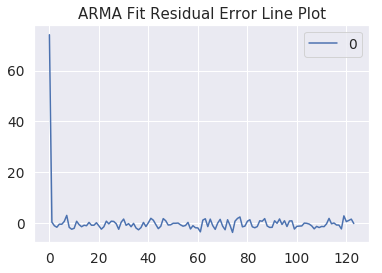

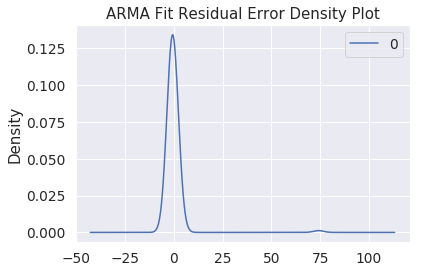

                  0
count  1.240000e+02
mean   9.463756e-16
std    6.847974e+00
min   -3.848948e+00
25%   -1.543951e+00
50%   -7.589516e-01
75%    5.510471e-01
max    7.415105e+01


In [95]:
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.title("ARMA Fit Residual Error Line Plot")
plt.show()
residuals.plot(kind='kde')
plt.title("ARMA Fit Residual Error Density Plot")
plt.grid("on")
plt.show()
print(residuals.describe())

## RMS

In [86]:
rms=np.sqrt(np.mean(np.power((np.array(history)-np.array(predictions)),2)))
print('RMS: ', rms)

RMS:  8.644035506873553


## Saving an ARIMA Time Series Forecasting Model

The statsmodels library provides an implementation of ARIMA for use in Python. ARIMA models can be saved to file for later use in making predictions on new data. There is a bug in the earlier versions to 0.9 of the statsmodels library that prevents saved models from being loaded.


In [87]:
print('statsmodels: %s' % statsmodels.__version__)

statsmodels: 0.9.0


In [88]:
# save model
model_fit.save('arima_model.pkl')


## Loading a model and predicting future prices

In [179]:
# load model
loaded = ARIMAResults.load('arima_model.pkl')
lookback_date = dt.date.today() - dt.timedelta(180)
start_d = dt.date.today()
#start_d = dt.datetime.strptime(start_d, '%Y-%m-%d')

end_d = dt.date.today() + dt.timedelta(7)
#end_d = dt.datetime.strptime(end_d, '%Y-%m-%d')

# Calculate steps
days = (end_d - start_d).days
forecast = loaded.forecast(steps=days)[0] 

# Setting dates for dataframe
dates = pd.date_range(start_d, periods=days)


df=pd.DataFrame(forecast)
df['Dates'] = dates
df.set_index('Dates', inplace=True)
df.rename(columns = {0:'Price'}, inplace=True)


/home/emi/miniconda3py37/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



## Plotting predictions

In [180]:
dates = pd.date_range(lookback_date, dt.date.today())
df_prices = slice_df(portf_value, dates)


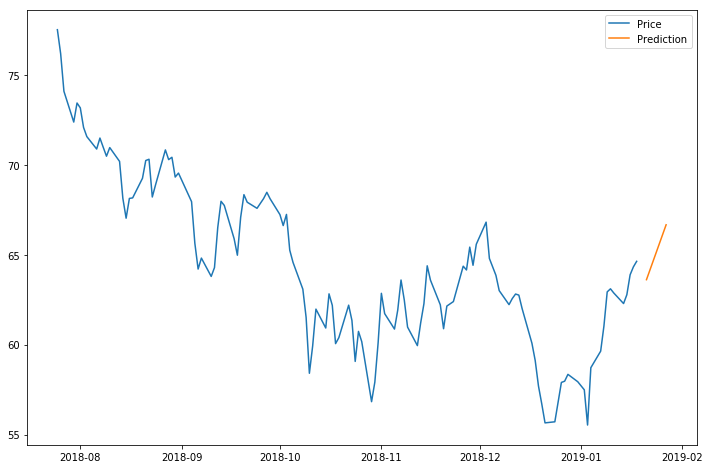

In [182]:
# plot
plt.figure(figsize=(12,8))
plt.plot(df_prices.index, df_prices['Adj Close'], label='Price')
plt.plot(df, label='Prediction')
plt.legend()


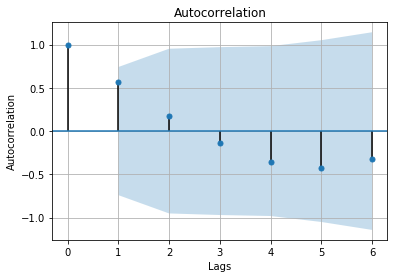

In [164]:


plot_acf(df['Price'])
plt.grid(True)
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

# LSTM Long Short-Term Memory

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:

    The input gate: The input gate adds information to the cell state
    The forget gate: It removes the information that is no longer required by the model
    The output gate: Output Gate at LSTM selects the information to be shown as output
